<a href="https://colab.research.google.com/github/Dienert/reviews_analyzer/blob/main/notebooks/5%20-%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

https://github.com/dipanjanS/nlp_workshop_odsc_europe20/blob/master/notebooks/Module_03_NLP%20Applications%20-%20Machine%20and%20Deep%20Learning/13_NLP_Applications_Text_Classification_Deep_Learning_Sequential_Models_LSTMs.ipynb

# Text Classification - Deep Learning LSTM Models

In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [3]:
label_type = 'final_label'

In [4]:
datasets_path = f'../dataset/{label_type}/'
# datasets_path = '.'

In [5]:
# %%skip $skip_download_dataset
# !curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/train.csv > train.csv
# !curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/val.csv > val.csv
# !curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/test.csv > test.csv

### Prepare Train Test Split

In [6]:
import pandas as pd

In [7]:
train = pd.read_csv(f'{datasets_path}/train.csv')
train

,x,y
0,Four Stars. thought provoking,1
1,Not What I Expected. Although a few of the sto...,0
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Surprisingly good..... .. Interesting connecti...,1
4,Success. Good book to read for success,2
...,...,...
3420,Thoughts on Gladwell's Outliers: An exceptiona...,2
3421,Spellbinding. I haven't read other Gladwell bo...,2
3422,Very Thought Provoking. Excellent book. This b...,2
3423,Very Interesting and Well Done. This book help...,1


In [8]:
train.y.value_counts()

2    1520
1    1231
0     674
Name: y, dtype: int64

In [9]:
train_sentiments = train.y.map({0: 'negative', 1:'negative', 2:'positive'})

In [10]:
train_sentiments.value_counts()

negative    1905
positive    1520
Name: y, dtype: int64

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
x_resampled, y_resampled = rus.fit_resample(train.x.values.reshape(-1,1), train_sentiments)

In [12]:
x_resampled

array([["Great Read. Would recommend.. Similar writing to his other works. I've really enjoyed the way he thinks."],
       ['Very interestings concepts. The ideas were very new and thought provoking. Some were logical and some were a surprise.'],
       ['All In Education Should Read This. This book should be an interesting read for anyone, but I particularly want to highlight the need for all educators to read it. Current educational policy needs a whack on the side of the head. (I write this as an experienced teacher neck deep in No Child Left Behind, and the policy makers\' forcing "research based strategies" into our lesson plans.) Do I think the research that Gladwell cites somehow trumps current mainstream educational research? Not necessarily. But it does give the reader a chance to pull their head out of today\'s pervasive educational group think and consider alternatives.'],
       ...,
       ['Spellbinding. I haven\'t read other Gladwell books but from what I\'ve heard, he\

In [13]:
x_resampled.shape

(3040, 1)

In [14]:
train_reviews = pd.Series(x_resampled.reshape(-1,))
train_reviews

0       Great Read. Would recommend.. Similar writing ...
1       Very interestings concepts. The ideas were ver...
2       All In Education Should Read This. This book s...
3       Worthy Read: Gladwell's Intent. No, it [excell...
4       Pretty good read.. Overall this is a pretty go...
                              ...                        
3035    Insightful, knowledgable and fun.. Brilliant b...
3036    Thoughts on Gladwell's Outliers: An exceptiona...
3037    Spellbinding. I haven't read other Gladwell bo...
3038    Very Thought Provoking. Excellent book. This b...
3039    Seeing the forest instead of the trees. Life i...
Length: 3040, dtype: object

In [15]:
train_sentiments = pd.Series(y_resampled)

In [16]:
train_sentiments.value_counts()

negative    1520
positive    1520
Name: y, dtype: int64

In [17]:
train_sentiments = train_sentiments.values

In [41]:
val = pd.read_csv(f'{datasets_path}/val.csv')
val

,x,y
0,Enlighting!. Very interesting book. It makes y...,1
1,Thoroughly enjoyed!. a highly relevant and wel...,2
2,a must read!. great book a must read!,2
3,Okay for a Used Book. It looks okay for a used...,0
4,Great service and Great book. Great arrival ti...,2
...,...,...
537,"Well written. The author, Malcolm Gladwell, pr...",2
538,Causes one to stop and think. Really an intere...,1
539,Very Interesting. Gladwell does looks at thing...,2
540,Wonderful. Bought this following a recommendat...,2


In [42]:
val_reviews = val.x
val_sentiments = val.y.map({0: 'negative', 1:'negative', 2:'positive'})
val_sentiments.value_counts()

negative    302
positive    240
Name: y, dtype: int64

In [43]:
val_sentiments = val_sentiments.values

In [44]:
test = pd.read_csv(f'{datasets_path}/test.csv')
test

,x,y
0,A great read and worth every penny!. My first ...,2
1,"Senior English. Dear Mr. Gladwell,  am a seni...",1
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Five Stars. I like Malcolm Gladwell books.,2
4,A Different Perspective on the Nature of Succe...,2
...,...,...
537,Worth the money. page quality is good but its ...,1
538,Absolute Genius. This is the first book I read...,2
539,Excellent book. Outliers is an intriguing book...,2
540,Another article turned into a book. This is ye...,0


In [45]:
test_reviews = test.x
test_sentiments = test.y.map({0: 'negative', 1:'negative', 2:'positive'})
test_sentiments.value_counts()

negative    302
positive    240
Name: y, dtype: int64

In [46]:
test_sentiments = test_sentiments.values

# Text Wrangling & Normalization

In [21]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [47]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_val_reviews = pre_process_corpus(val_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 542/542 [00:00<00:00, 5474.95it/s]

CPU times: total: 906 ms
Wall time: 912 ms


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [48]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [49]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('unfairly', 7566), ('<PAD>', 0), 1)

In [50]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [52]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [53]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=7567
Number of Documents=3040


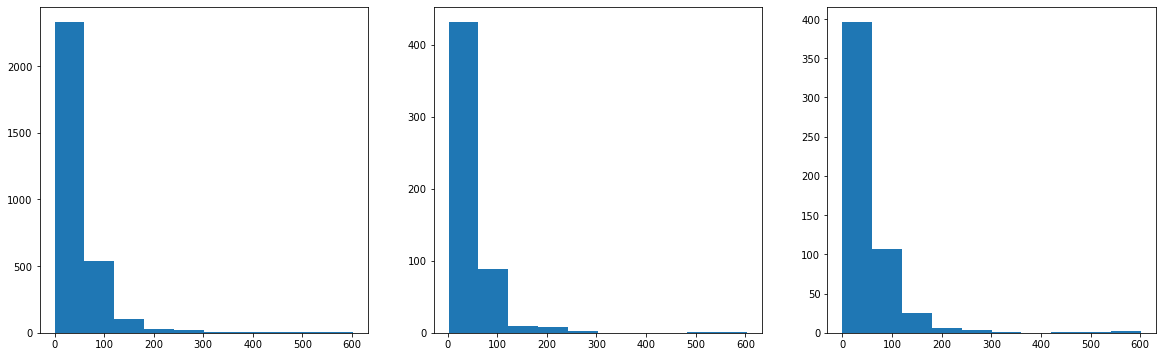

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
val_lens = [len(s) for s in val_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,3, figsize=(20, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(val_lens)
h3 = ax[2].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [60]:
MAX_SEQUENCE_LENGTH = 1000

In [62]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_val.shape, X_test.shape

((3040, 1000), (542, 1000), (542, 1000))

In [63]:
X_train

array([[   0,    0,    0, ...,   76,   38,  855],
       [   0,    0,    0, ...,   81,    5, 1687],
       [   0,    0,    0, ...,    3,  527, 3076],
       ...,
       [   0,    0,    0, ...,    9,  400,  113],
       [   0,    0,    0, ...,   41,   26,   55],
       [   0,    0,    0, ..., 7565,   97, 7566]])

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [64]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [65]:
y_train = le.fit_transform(train_sentiments)
y_val = le.fit_transform(val_sentiments)
y_test = le.transform(test_sentiments)

# LSTM Model

# Build Model Architecture


# Embeddings

The Embedding layer helps us generate the word embeddings from scratch. This layer
is also initialized with some weights and is updated based on our optimizer, similar to
weights on the neuron units in other layers when the network tries to minimize the loss
in each epoch. Thus, the embedding layer tries to optimize its weights such that we get
the best word embeddings that will generate minimum error in the model and capture
semantic similarity and relationships among words. How do we get the embeddings?
Let’s say we have a review with three terms ['movie', 'was', 'good'] and a vocab_map
consisting of word to index mappings for 175860 words. 

![](https://i.imgur.com/WuV47DW.png)


# LSTM

LSTMs try to overcome
the shortcomings of RNN models, especially with regard to handling long-term
dependencies and problems that occur when the weight matrix associated with the
units (neurons) become too small (leading to vanishing gradient) or too large (leading to
exploding gradient). These architectures are more complex than regular deep networks
and going into detailed internals and math concepts are out of the current scope, but we
will try to cover the essentials here without making it math heavy

![](https://i.imgur.com/c8qGKX8.png)

The sequence of operations in the LSTM cell is briefly shown as follows.

![](https://i.imgur.com/uiIbDk1.png)

In [34]:
import tensorflow as tf

In [36]:
VOCAB_SIZE = len(t.word_index)

In [68]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 300)         2270100   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 2,523,029
Trainable params: 2,523,029
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [ ]:
model.fit()

In [69]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
24/24 [==============================] - 245s 10s/step - loss: 0.6717 - accuracy: 0.5816 - val_loss: 0.6418 - val_accuracy: 0.6218
Epoch 2/10
24/24 [==============================] - 246s 10s/step - loss: 0.4758 - accuracy: 0.7757 - val_loss: 0.5151 - val_accuracy: 0.7325
Epoch 3/10
24/24 [==============================] - 254s 11s/step - loss: 0.2555 - accuracy: 0.9030 - val_loss: 0.5258 - val_accuracy: 0.7989
Epoch 4/10
24/24 [==============================] - 256s 11s/step - loss: 0.1268 - accuracy: 0.9520 - val_loss: 0.5868 - val_accuracy: 0.8100
Epoch 00004: early stopping


## Evaluate Model Performance

In [70]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17/17 [==============================] - 6s 342ms/step - loss: 0.4885 - accuracy: 0.7601
Accuracy: 76.01%


In [71]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0])

In [72]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['positive',
 'negative',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'negative',
 'negative']

In [73]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.76      0.83      0.79       302
    positive       0.76      0.67      0.71       240

    accuracy                           0.76       542
   macro avg       0.76      0.75      0.75       542
weighted avg       0.76      0.76      0.76       542



,negative,positive
negative,252,50
positive,80,160


# Stacked LSTM Model

## Build Model Architecture

In [74]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 300)         2270100   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 300)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 128)         219648    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 2,654,613
Trainable params: 2,654,613
Non-trainable params: 0
____________________________________________

## Train Model

In [75]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
           callbacks=[es],
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
22/22 [==============================] - 525s 24s/step - loss: 0.6639 - accuracy: 0.6023 - val_loss: 0.8268 - val_accuracy: 0.3059
Epoch 2/10
22/22 [==============================] - 558s 25s/step - loss: 0.4616 - accuracy: 0.7811 - val_loss: 0.4079 - val_accuracy: 0.8125
Epoch 3/10
22/22 [==============================] - 573s 26s/step - loss: 0.2444 - accuracy: 0.9020 - val_loss: 0.5674 - val_accuracy: 0.7599
Epoch 4/10
22/22 [==============================] - 576s 26s/step - loss: 0.1249 - accuracy: 0.9569 - val_loss: 1.0066 - val_accuracy: 0.8026
Epoch 00004: early stopping


## Evaluate Model Performance

In [76]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17/17 [==============================] - 13s 794ms/step - loss: 0.4992 - accuracy: 0.7601
Accuracy: 76.01%


In [77]:
predictions = model2.predict_classes(X_test).ravel()
predictions[:10]

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 0])

In [78]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative']

In [79]:
labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.81      0.75      0.78       302
    positive       0.71      0.78      0.74       240

    accuracy                           0.76       542
   macro avg       0.76      0.76      0.76       542
weighted avg       0.76      0.76      0.76       542



,negative,positive
negative,226,76
positive,54,186
